In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline


df = pd.read_csv("defaults.csv", header = 1, index_col = 'ID')
df.columns = [x.lower() for x in list(df.columns)]
df.columns = ['credit_amount', 'sex', 'education', 'marital_status', 'age', 'pay_sept', 'pay_aug',
       'pay_jul', 'pay_jun', 'pay_may', 'pay_apr', 'bill_amt_sept', 'bill_amt_aug',
       'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept',
       'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr',
       'default']

for column in ['credit_amount', 'bill_amt_sept', 'bill_amt_aug',
       'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept',
       'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr']:
    df[column] = df[column]/1000
    
gender_remapping = {1: 'male', 2: 'female'}
df.sex = df.sex.map(gender_remapping)

df.education = df.education.astype(str)
education_remapping = {'1': 'grad_school', '2': 'bachelors', '3': 'high_school', '4': 'other', 
                       '5': 'other', '6': 'other', '0': 'other'}
df.education = df.education.map(education_remapping)

df.marital_status = df.marital_status.astype(str)
marital_status_remapping = {'1': 'married', '2': 'single', '3': 'divorced', '0': 'other'}
df.marital_status = df.marital_status.map(marital_status_remapping)

# Original dataset

In [6]:
df.head()

,credit_amount,sex,education,marital_status,age,pay_sept,pay_aug,pay_jul,pay_jun,pay_may,...,bill_amt_jun,bill_amt_may,bill_amt_apr,pay_amt_sept,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20.0,female,bachelors,married,24,2,2,-1,-1,-2,...,0.000,0.000,0.000,0.000,0.689,0.0,0.0,0.000,0.000,1
2,120.0,female,bachelors,single,26,-1,2,0,0,0,...,3.272,3.455,3.261,0.000,1.000,1.0,1.0,0.000,2.000,1
3,90.0,female,bachelors,single,34,0,0,0,0,0,...,14.331,14.948,15.549,1.518,1.500,1.0,1.0,1.000,5.000,0
4,50.0,female,bachelors,married,37,0,0,0,0,0,...,28.314,28.959,29.547,2.000,2.019,1.2,1.1,1.069,1.000,0
5,50.0,male,bachelors,married,57,-1,0,-1,0,0,...,20.940,19.146,19.131,2.000,36.681,10.0,9.0,0.689,0.679,0


In [7]:
df.columns

Index(['credit_amount', 'sex', 'education', 'marital_status', 'age',
       'pay_sept', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr',
       'bill_amt_sept', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun',
       'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept', 'pay_amt_aug',
       'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr', 'default'],
      dtype='object')

# Creating dummy variable for categorical features and standardizing numerical features

In [8]:
# Creating dummy variables for 'sex', 'education', 'marital_status' columns
df_categ_dummies = pd.get_dummies(df[['sex','education','marital_status']])

# Considering only numerical columns from the original dataframe df
df_numerical = df.drop(['sex', 'education', 'marital_status', 'default'], axis=1)

# Performing standard scaling of df_numerical
stdsc = StandardScaler()
numerical_std = stdsc.fit_transform(df_numerical)
df_numerical_std = pd.DataFrame(numerical_std, 
                               columns = df_numerical.columns,
                               index = df_numerical.index)

# Combining three dataframes: 1st - contains numerical standardized features, 2nd - categorical dummy variables, 3rd - 'default' column from the original dataframe (customer defaulted = 1, not defaulted  = 0).  

In [9]:
df_ml = pd.concat([df_categ_dummies, df_numerical_std, df[['default']]], axis = 1)

In [10]:
df_ml.head()

,sex_female,sex_male,education_bachelors,education_grad_school,education_high_school,education_other,marital_status_divorced,marital_status_married,marital_status_other,marital_status_single,...,bill_amt_jun,bill_amt_may,bill_amt_apr,pay_amt_sept,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr,default
ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,0,0,0,1,0,0,...,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,1
2,1,0,1,0,0,0,0,0,0,1,...,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,1
3,1,0,1,0,0,0,0,0,0,1,...,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0
4,1,0,1,0,0,0,0,1,0,0,...,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,0
5,0,1,1,0,0,0,0,1,0,0,...,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,0


In [11]:
df_ml.columns

Index(['sex_female', 'sex_male', 'education_bachelors',
       'education_grad_school', 'education_high_school', 'education_other',
       'marital_status_divorced', 'marital_status_married',
       'marital_status_other', 'marital_status_single', 'credit_amount', 'age',
       'pay_sept', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr',
       'bill_amt_sept', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun',
       'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept', 'pay_amt_aug',
       'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr', 'default'],
      dtype='object')

# Learning curve plotting function

In [12]:
def learning_curve_plot(X_train, y_train, clf, clf_name):
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=clf, 
                    X=X_train, 
                    y=y_train,
                    train_sizes=np.linspace(0.1, 1.0, 5),
                    cv=10,
                    n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, 
             color='blue', marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(train_sizes, 
                     train_mean + train_std,
                     train_mean - train_std, 
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, 
             color='green', linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(train_sizes, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color='green')

    plt.grid()
    plt.title('Learning curve for ' + str(clf_name))
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([min(test_mean) - 0.025, max(train_mean) + 0.025])
    plt.tight_layout()
    return plt

# Validation curves plotting function

In [13]:
def validation_curve_plot(X_train, y_train, clf, param_range, param_name, clf_name):

    train_scores, test_scores = validation_curve(
                    estimator=clf, 
                    X=X_train, 
                    y=y_train, 
                    param_name=param_name, 
                    param_range=param_range,
                    cv=10,
                    n_jobs = -1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(param_range, train_mean, 
             color='blue', marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color='blue')

    plt.plot(param_range, test_mean, 
             color='green', linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color='green')

    plt.grid()
    plt.xscale('log')
    plt.legend(loc='lower right')
    plt.xlabel('Parameter ' + str(param_name))
    plt.ylabel('Accuracy')
    plt.title('Validation curve for ' + str(clf_name))
    plt.ylim([min(test_mean) - 0.025, max(train_mean) + 0.025])
    plt.tight_layout()
    return plt

# Training and test split

In [14]:
X = df_ml.drop(['default'], axis = 1).values
y = df_ml[['default']].values.ravel()

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.20, random_state=1)

# Logistic regression

In [11]:
clf = LogisticRegression(solver = 'lbfgs', max_iter = 250)

# Fit the model on the trainng data.
clf.fit(X_train, y_train)

print('Training accuracy:', accuracy_score(clf.predict(X_train), y_train))
print('Test accuracy:', accuracy_score(clf.predict(X_test), y_test))

Training accuracy: 0.811666666667
Test accuracy: 0.809


# Stratified K-fold cross-validation (logistic regression).

In [12]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for k, (train, test) in enumerate(kfold.split(X,y)):
    clf.fit(X[train], y[train])
    score = clf.score(X[test], y[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Train accuracy: %.3f' % (k+1, np.bincount(y[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [18691  5308], Train accuracy: 0.811
Fold: 2, Class dist.: [18691  5309], Train accuracy: 0.814
Fold: 3, Class dist.: [18691  5309], Train accuracy: 0.810
Fold: 4, Class dist.: [18691  5309], Train accuracy: 0.810
Fold: 5, Class dist.: [18692  5309], Train accuracy: 0.810

CV accuracy: 0.811 +/- 0.002


# Validation curve (logistic regression)

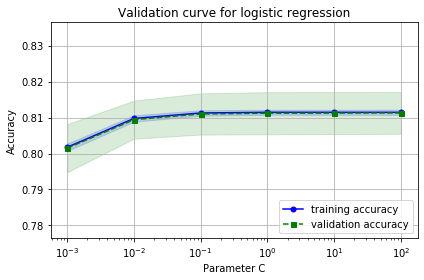

In [15]:
clf_param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

validation_curve_plot(X_train, y_train, clf, clf_param_range, 'C', 'logistic regression').show()

# Hyperparameter tuning using grid search (logistic regression)

In [16]:
C_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

param_grid = [{'C': C_range, 'solver': solvers}]

gs = GridSearchCV(estimator=clf, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.811291666667
{'C': 10.0, 'solver': 'newton-cg'}


In [17]:
best_clf = gs.best_estimator_
best_clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % best_clf.score(X_test, y_test))

Test accuracy: 0.809


# Learning curve (logistic regression)

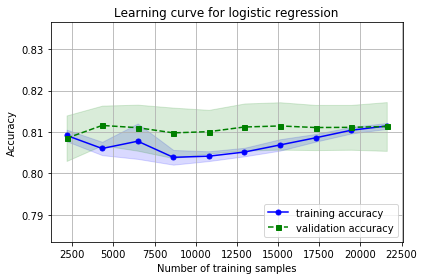

In [18]:
learning_curve_plot(X_train, y_train, best_clf, 'logistic regression').show()

# Confusion matrix (logistic regression)

In [19]:
y_pred = best_clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[4550  113]
 [1033  304]]


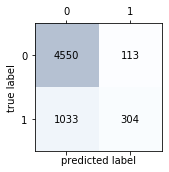

In [20]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

**We want to have 1 as a positive class in the confusion matric in the top left corner, therefore we need to swap labels in the confusion matrix.**

**1 - default**
**0 - no default**

In [21]:
y_pred = best_clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = [1,0])
print(confmat)

[[ 304 1033]
 [ 113 4550]]


In [22]:
print('Precisoin from the above matrix = ' + str(confmat[0][0]/(confmat[0][0] + confmat[1][0])))

Precisoin from the above matrix = 0.729016786571


**Metrics using sklearn precision_score() function**

In [23]:
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.729
Recall: 0.227
F1: 0.347


# k - Nearest Neighbour (kNN)

In [27]:
knn = KNeighborsClassifier()

# Fit the model on the trainng data.
knn.fit(X_train, y_train)

print('Training accuracy:', accuracy_score(knn.predict(X_train), y_train))
print('Test accuracy:', accuracy_score(knn.predict(X_test), y_test))

Training accuracy: 0.844791666667
Test accuracy: 0.79


# Validation curve (kNN)

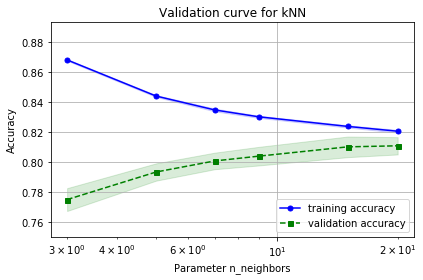

In [28]:
n_neigbors_val = [3, 5, 7, 9, 15, 20]

validation_curve_plot(X_train, y_train, knn, n_neigbors_val, 'n_neighbors', 'kNN').show()

# Learning curve (kNN)

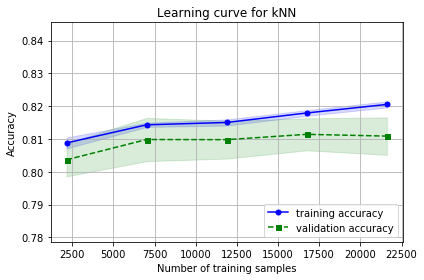

In [31]:
learning_curve_plot(X_train, y_train, 
                    KNeighborsClassifier(n_neighbors = 20, n_jobs = -1), 
                    'kNN').show()

# Confusion matrix (kNN)

In [33]:
best_knn = KNeighborsClassifier(n_neighbors = 20, n_jobs = -1)
best_knn.fit(X_train, y_train)
y_pred_knn = best_knn.predict(X_test)
confmat_knn = confusion_matrix(y_true=y_test, y_pred=y_pred_knn, labels = [1,0])
print(confmat_knn)

[[ 412  925]
 [ 213 4450]]


In [34]:
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred_knn))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred_knn))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred_knn))

Precision: 0.659
Recall: 0.308
F1: 0.420


# Random Forest classifier

In [17]:
rand_forest = RandomForestClassifier(n_jobs = -1)

# Fit the model on the trainng data.
rand_forest.fit(X_train, y_train)

print('Training accuracy:', accuracy_score(rand_forest.predict(X_train), y_train))
print('Test accuracy:', accuracy_score(rand_forest.predict(X_test), y_test))

//anaconda/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training accuracy: 0.978458333333
Test accuracy: 0.8075


# Validation curve (random forest)

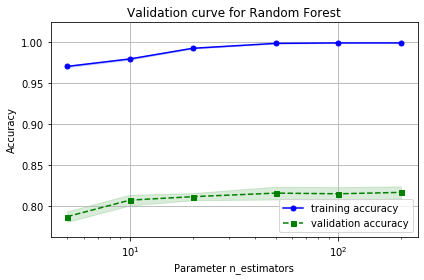

In [16]:
n_estimators = [5, 10, 20, 50, 100, 200]

validation_curve_plot(X_train, y_train, rand_forest, n_estimators, 'n_estimators', 'Random Forest').show()

# Confusion matrix (random forest)

In [18]:
best_rand_forest = RandomForestClassifier(n_estimators = 50, n_jobs = -1)
best_rand_forest.fit(X_train, y_train)
y_pred_rand_forest = best_rand_forest.predict(X_test)
confmat_rand_forest = confusion_matrix(y_true=y_test, y_pred=y_pred_rand_forest, labels = [1,0])
print(confmat_rand_forest)

[[ 461  876]
 [ 250 4413]]


In [19]:
print('Precision (random forest): %.3f' % precision_score(y_true=y_test, y_pred=y_pred_rand_forest))
print('Recall (random forest): %.3f' % recall_score(y_true=y_test, y_pred=y_pred_rand_forest))
print('F1 (random forest): %.3f' % f1_score(y_true=y_test, y_pred=y_pred_rand_forest))

Precision (random forest): 0.648
Recall (random forest): 0.345
F1 (random forest): 0.450
